## OCR Tests

__Test 1__: Can we use OCR tools to detect bad label results?

__Test 2__: What things affect OCR results?

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import skimage.io as io
import tqdm
import pytesseract
from textwrap import wrap
# Main functions: transform_label, find_aligned_label
from source_functions.main import *
from source_functions.label_merging import align_merged_label
from source_functions.alignment_helper_functions import combine_masks

#### Paths / Sample

In [3]:
pth_to_images1 = '../../ALICE_Data/resized/train'
pth_to_images2 = '../../ALICE_Data/resized/val'
pth_to_masks = 'CNN_Results/sample_tests/samp_masks'

In [4]:
df = pd.read_csv('sample_names.csv')
df['Mask_Path'] = [pth_to_masks+'/'+f for f in df['Mask']]

img_paths = []

for img in df['Image']:
    try:
        img_pth = pth_to_images1+'/'+img
        _ = io.imread(img_pth)
    except:
        img_pth = pth_to_images2+'/'+img
    img_paths.append(img_pth)
    
df['Image_Path'] = img_paths
specimen_sample = np.unique(df['Position_ID'])

#### Pin Masks

In [5]:
pin_pth = 'CNN_Results/sample_tests/pins/samp_masks'

files = []
files_trim = []
for file in os.listdir(pin_pth):
    files.append(file)
    files_trim.append(file[:-6]+'.JPG')
    
df_pin = pd.DataFrame([files,files_trim]).T

pin_names = np.unique(list(df_pin[1]))

all_pin_masks = {}

for nm in tqdm.tqdm(pin_names):
    pin_msks = list(df_pin[df_pin[1]==nm][0])
    
    try:
        img_orig = io.imread(pth_to_images1+'/'+nm)
    except:
        img_orig = io.imread(pth_to_images2+'/'+nm)

    msk_img = deepcopy(img_orig)

    for msk in pin_msks:
        msk_pth = pin_pth+'/'+msk
        mask_pin = np.load(msk_pth)
        msk_img[np.where(mask_pin==True)] = [255,0,0]

    all_pin_masks[nm] = msk_img

100%|███████████████████████████████████████████| 40/40 [00:02<00:00, 16.10it/s]


#### Aligned Labels

In [6]:
label_results = {}
errors = []

for img_id in tqdm.tqdm(pd.unique(df['Position_ID'])):

    try:
        all_images,transformed,merged = find_aligned_label(img_id,df,all_pin_masks,
        remove_pin=True,template_option=2,ydist=True,align=True,
        combine_extra_masks = True,template_label=None,merge_method=0,filter_imgs=True,
                                              label_method=1,reconfig_method=0)
        aligned = align_merged_label(merged)

        label_results.update({img_id:{"orig" : all_images[0],"transformed":transformed,
                                      "merged":merged,"final" : aligned}})
    except:
        errors.append(img_id)

100%|███████████████████████████████████████████| 19/19 [02:43<00:00,  8.60s/it]


In [15]:
print("Total errors: "+str(len(errors)))

Total errors: 0


(0.0, 1.0, 0.0, 1.0)

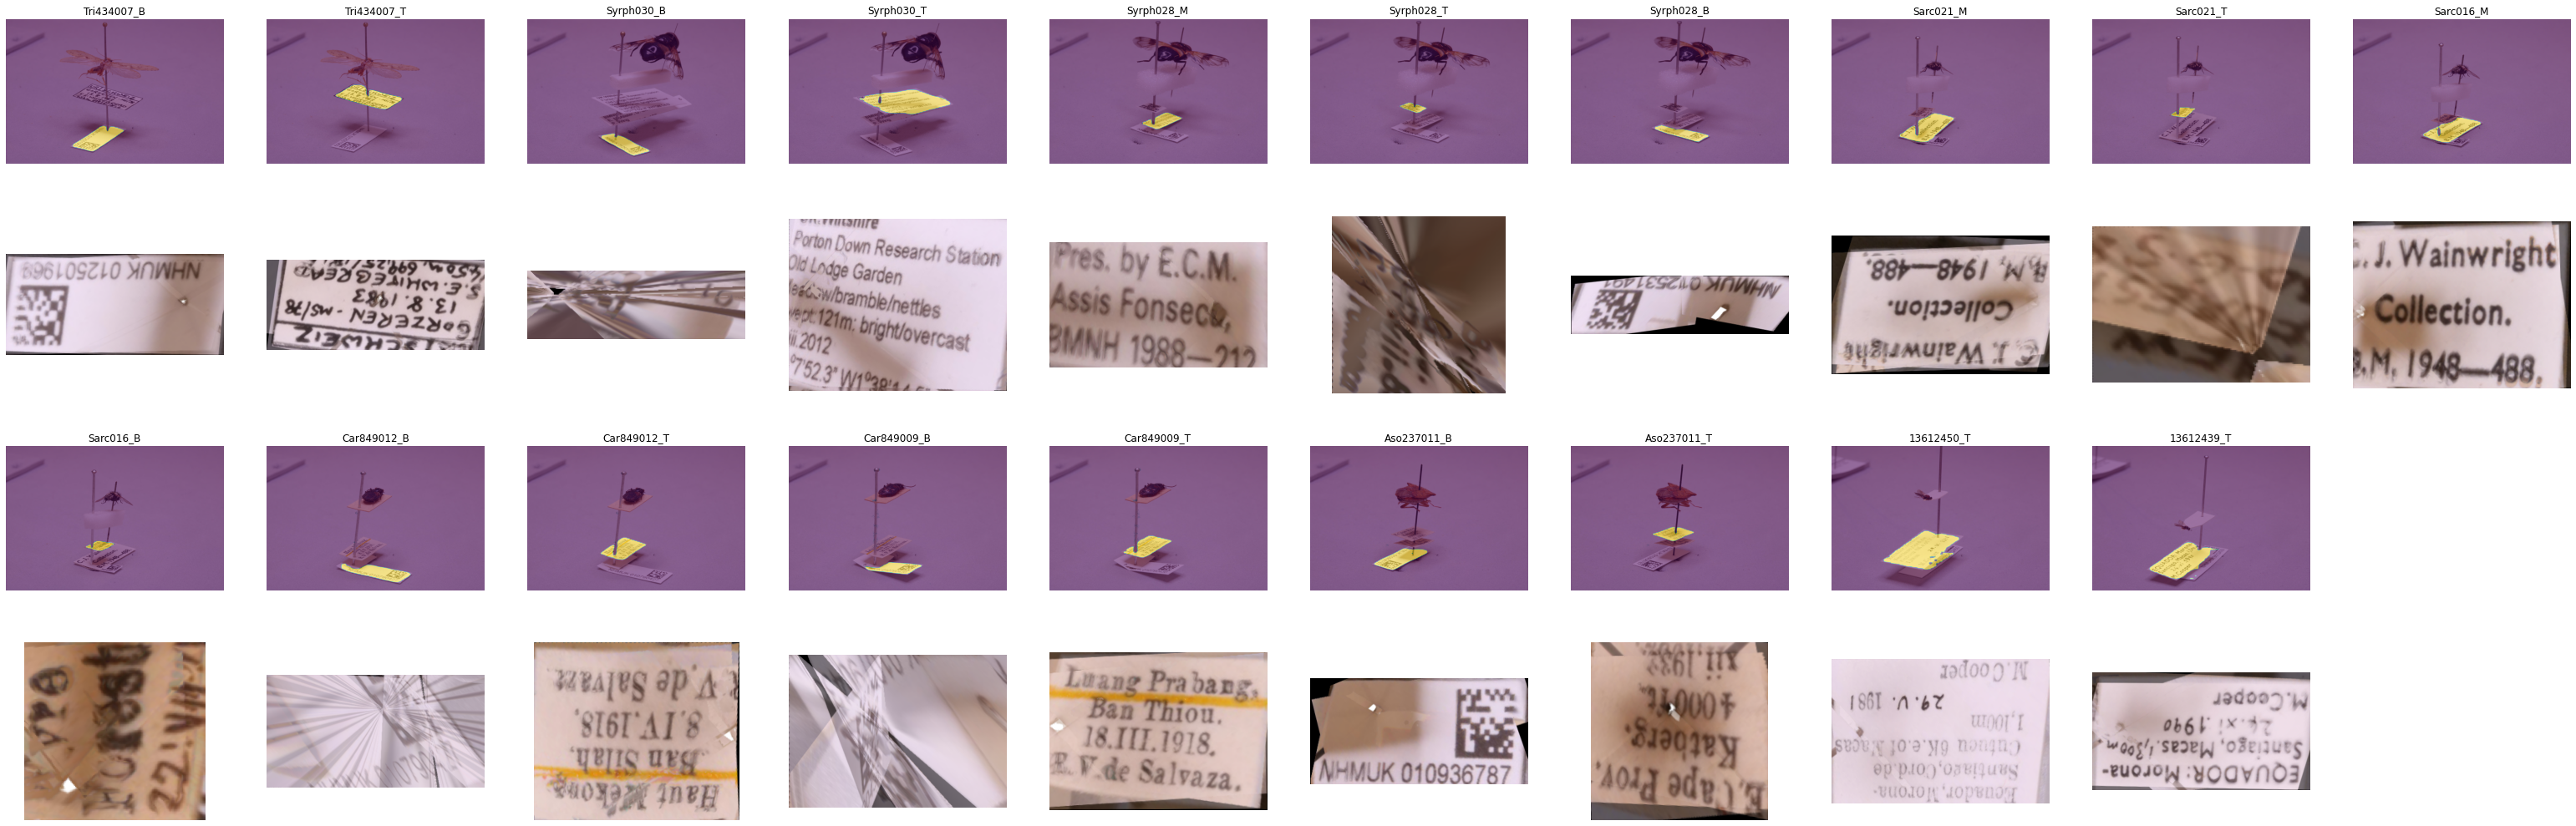

In [20]:
samp = pd.unique(df['Position_ID'])

fig,ax = plt.subplots(4,10,figsize=(5.5*10,4.5*4))

j = 0

for i,img_id in enumerate(samp):
    
    if (i%10==0) and (i!=0):
        j = 2
    
    # Plot original image:
    bla = df[df['Position_ID']==img_id].reset_index()
    imgpth = bla['Image_Path'].iloc[0]
    mskpth = bla['Mask_Path'].iloc[0]
    img = io.imread(imgpth)
    msk = np.load(mskpth)
    ax[j,i%10].imshow(img)
    ax[j,i%10].imshow(msk,alpha=0.5)
    ax[j,i%10].set_title(img_id)
    ax[j,i%10].axis('off')
    
    # Aligned Image #1
    if img_id not in errors:
        ax[j+1,i%10].imshow(label_results[img_id]["final"])
        ax[j+1,i%10].axis('off')
        
ax[2,9].axis('off')
ax[3,9].axis('off')

### Detecting Bad Results

__Idea__: Using OCR tools, if no text can be found then image is classified as _bad_.

In [64]:
def check_orientation(image,bound_percentile=50,rotate="osd"):
    img_bin = bin_image(image,bound_percentile=bound_percentile)
    if rotate=="osd":
        osd = pytesseract.image_to_osd(img_bin,config=
                                   '--psm 0 -c min_characters_to_try=5 script=Latin')
        rotation = np.int_(re.findall('\d+',osd)[1:3])

        if rotation[0] == 180:
            image = imutils.rotate_bound(image, rotation[1])
            img_bin = imutils.rotate_bound(img_bin, rotation[1])
    else:
        image = imutils.rotate_bound(image, rotate)
        img_bin = imutils.rotate_bound(img_bin, rotate)

    return image, img_bin

In [33]:
samp = pd.unique(df['Position_ID'])

(0.0, 1.0, 0.0, 1.0)

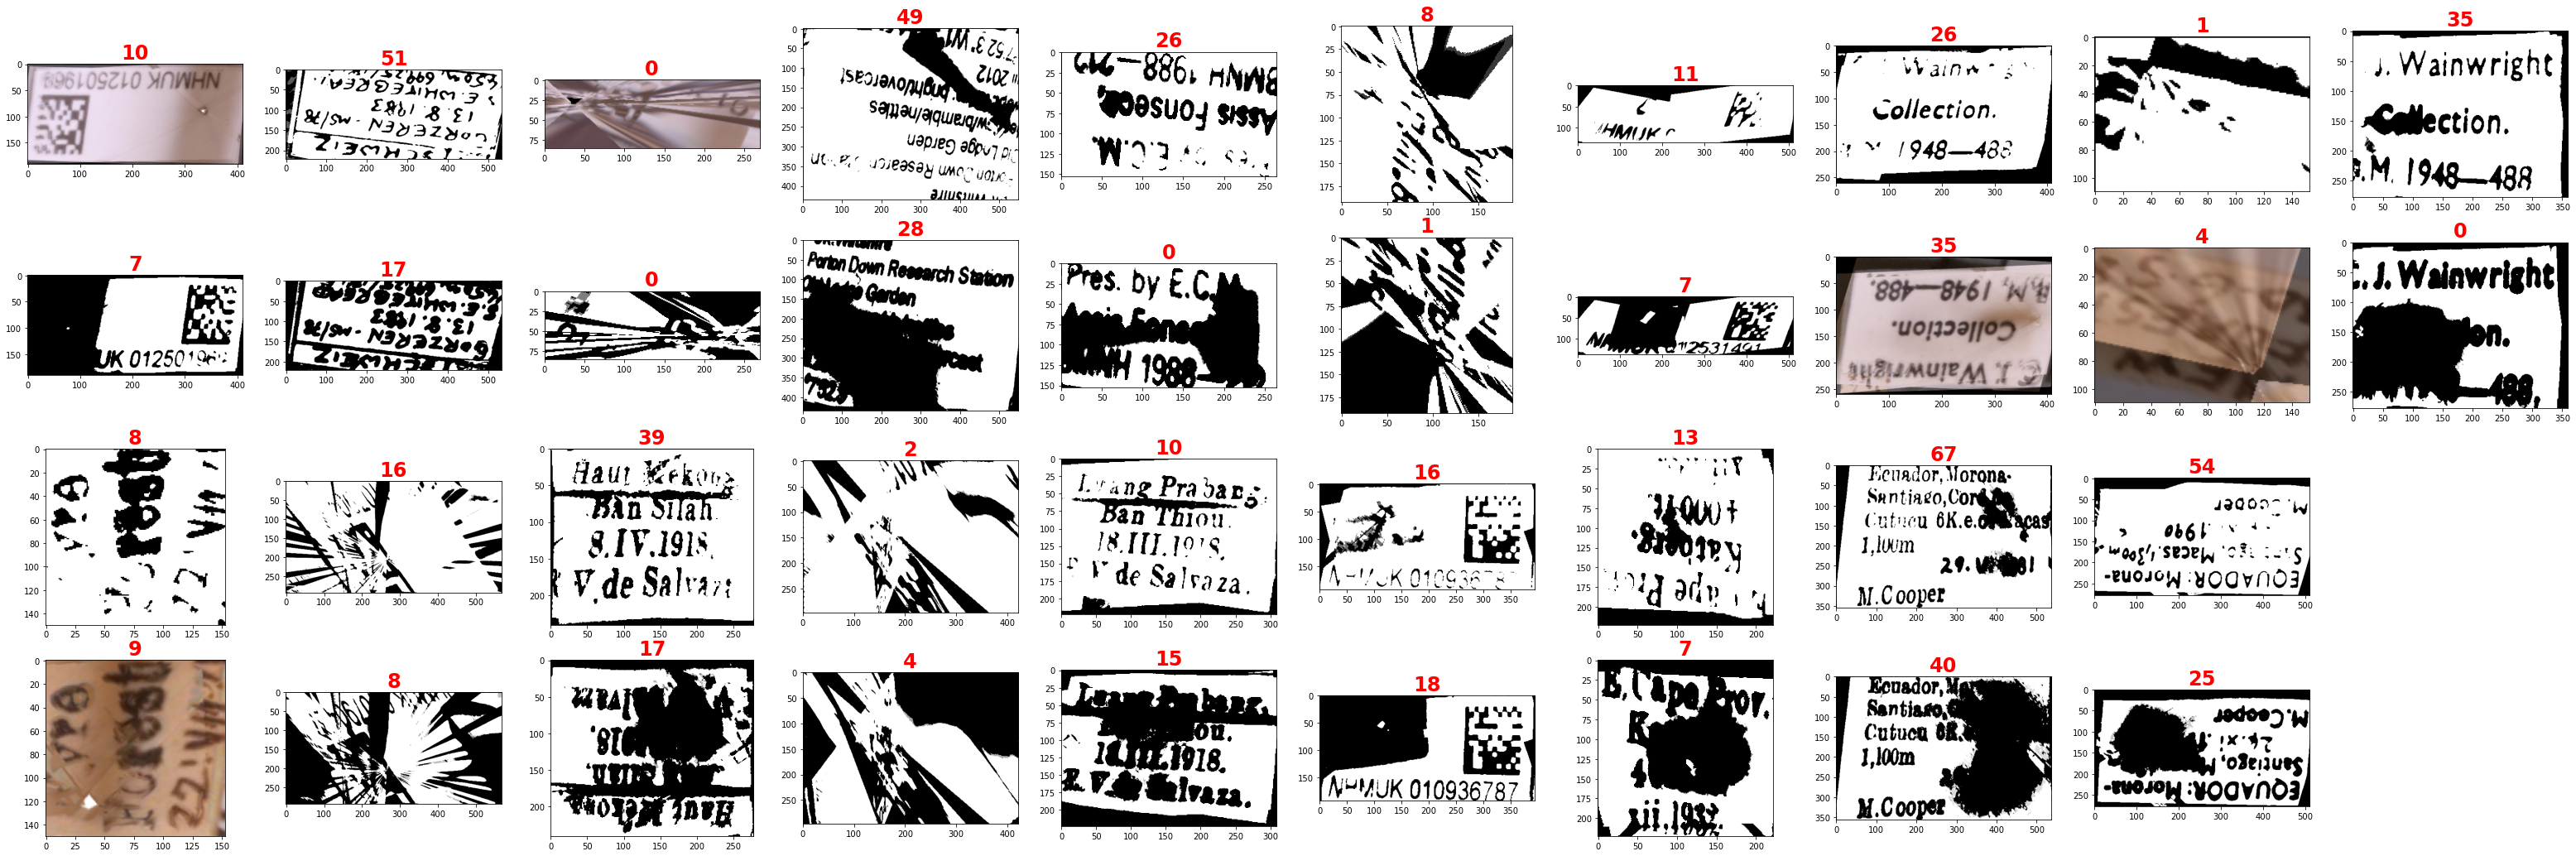

In [38]:
fig,ax = plt.subplots(4,10,figsize=(5.5*10,4.5*4))

j = 0

results1 = []
results2 = []

for i,img_id in enumerate(samp):
    
    if (i%10==0) and (i!=0):
        j = 2
    
    try:
        image, image2 = check_orientation(label_results[img_id]["final"],bound_percentile=20)
    except:
        image = label_results[img_id]["final"]
        image2 = label_results[img_id]["final"]
        
    results = pytesseract.image_to_string(image2, config='--psm 11 script=Latin')
    res = " ".join(re.findall('\w+',results))
    
    results1.append(res)

    ax[j,i%10].imshow(image2,cmap='gray')
    
    ax[j,i%10].set_title(str(len(res)),fontsize=24,fontweight="bold",color='r')
    
    try:
        image, image2 = check_orientation(label_results[img_id]["final"],bound_percentile=50)
    except:
        image = label_results[img_id]["final"]
        image2 = label_results[img_id]["final"]
        
    results = pytesseract.image_to_string(image2, config='--psm 11 script=Latin')
    res = " ".join(re.findall('\w+',results))
    
    results2.append(res)

    ax[j+1,i%10].imshow(image2,cmap='gray')
    
    ax[j+1,i%10].set_title(str(len(res)),fontsize=24,fontweight="bold",color='r')

ax[2,9].axis('off')
ax[3,9].axis('off')

__Idea__: Classify as _bad_ if the number of characters found using OCR methods is less than a bound, e.g., $k=10$, when OCR is applied to both the binarized image with `bound_percentile=50` and the binarized image with  `bound_percentile=20`.

In [74]:
def ocr(img):
    results = pytesseract.image_to_string(img, config='--psm 11 script=Latin')
    res = " ".join(re.findall('\w+',results))
    return res

In [75]:
def basic_ocr(img,bound_percentile=50,rotate="osd"):
    try:
        image, image_bin = check_orientation(img,bound_percentile=bound_percentile,rotate=rotate)
    except:
        image = deepcopy(img)
        image_bin = deepcopy(img)
        
    res = ocr(image_bin)
    
    return image,image_bin,res

In [50]:
def detect_bad(img):
    _,_,res1 = basic_ocr(img,bound_percentile=50)
    _,_,res2 = basic_ocr(img,bound_percentile=20)
    return all(i<10 for i in [len(res1),len(res2)])

(0.0, 1.0, 0.0, 1.0)

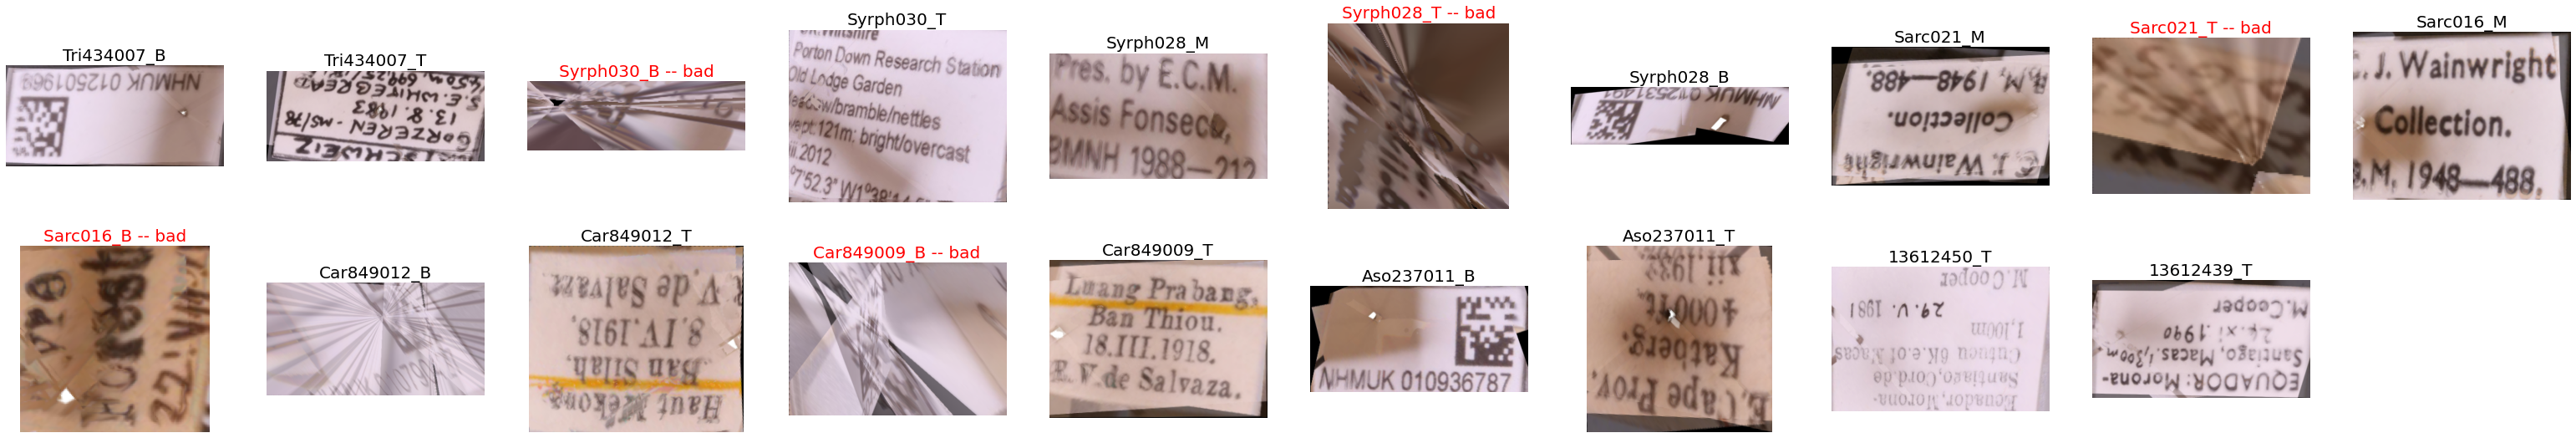

In [54]:
fig,ax = plt.subplots(2,10,figsize=(5.5*10,4.5*2))

j = 0

for i,img_id in enumerate(samp):
    
    if (i%10==0) and (i!=0):
        j = j+1
        
    img = label_results[img_id]["final"]
    ax[j,i%10].imshow(img)
    
    bad = detect_bad(img)
    
    if bad == True:
        ax[j,i%10].set_title(img_id+' -- bad',color='r',fontsize=20)
    else:
        ax[j,i%10].set_title(img_id,color='k',fontsize=20)

    ax[j,i%10].axis('off')
        
ax[1,9].axis('off')

### OCR Tests

__Question 1__: Do incorrectly rotated images affect basic OCR results?


__TL;DR__: Seems so.

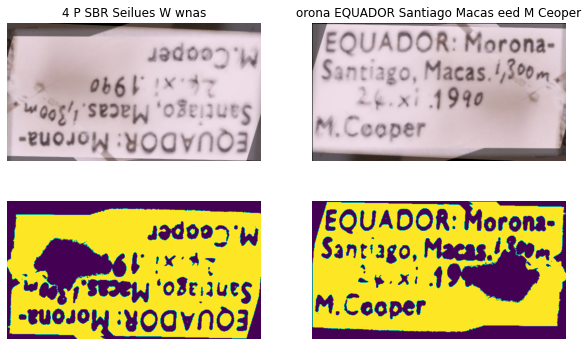

In [73]:
image1,image_bin1,res1 = basic_ocr(img,bound_percentile=35)
image2,image_bin2,res2 = basic_ocr(img,bound_percentile=35,rotate=180)

fig,ax = plt.subplots(2,2,figsize=(10,6))
ax[0,0].imshow(image1)
ax[0,1].imshow(image2)
ax[1,0].imshow(image_bin1)
ax[1,1].imshow(image_bin2)
ax[0,0].set_title(res1)
ax[0,1].set_title(res2)

for i in [0,1]:
    for j in [0,1]:
        ax[i,j].axis('off')

__Question 2__: What are the differences between OCR on a coloured image, greyscaled image and binarized image?

Text(0.5, 1.0, 'orona EQUADOR Santiago Macas\need M Ceoper')

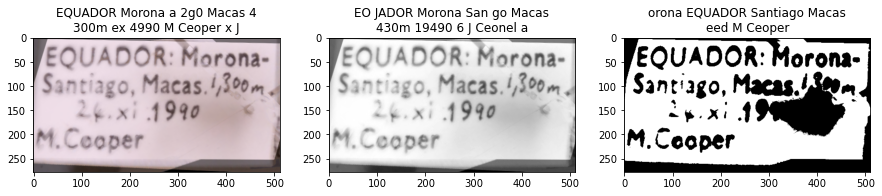

In [84]:
img_col = deepcopy(image2)
img_gry = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img_bin = bin_image(image2,bound_percentile=35)

res1 = ocr(img_col)
res2 = ocr(img_gry)
res3 = ocr(img_bin)

fig,ax = plt.subplots(1,3,figsize=(3*5,3))
ax[0].imshow(img_col)
ax[0].set_title('\n'.join(wrap(res1,30)))
ax[1].imshow(img_gry,cmap='gray')
ax[1].set_title('\n'.join(wrap(res2,30)))
ax[2].imshow(img_bin,cmap='gray')
ax[2].set_title('\n'.join(wrap(res3,30)))

Text(0.5, 1.0, 'ecuador M Santiago Cutucu 6K e\n1 100m A M Cooper')

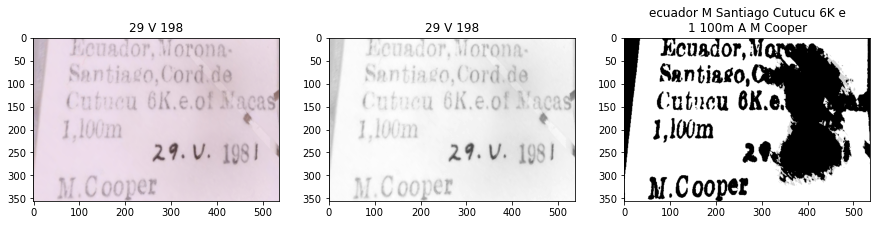

In [86]:
img = label_results[samp[-2]]["final"]
image2,image_bin2,res2 = basic_ocr(img,rotate=180)


img_col = deepcopy(image2)
img_gry = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img_bin = bin_image(image2,bound_percentile=35)

res1 = ocr(img_col)
res2 = ocr(img_gry)
res3 = ocr(img_bin)

fig,ax = plt.subplots(1,3,figsize=(3*5,3))
ax[0].imshow(img_col)
ax[0].set_title('\n'.join(wrap(res1,30)))
ax[1].imshow(img_gry,cmap='gray')
ax[1].set_title('\n'.join(wrap(res2,30)))
ax[2].imshow(img_bin,cmap='gray')
ax[2].set_title('\n'.join(wrap(res3,30)))

Text(0.5, 1.0, '0125019')

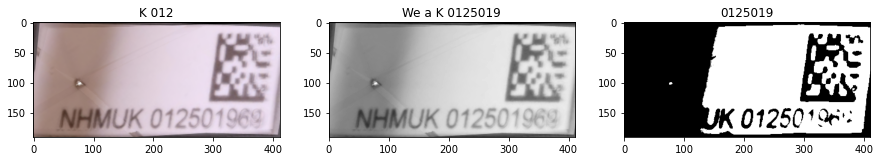

In [99]:
img = label_results[samp[0]]["final"]
image2,image_bin2,res2 = basic_ocr(img,rotate=180)


img_col = deepcopy(image2)
img_gry = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
img_bin = bin_image(image2,bound_percentile=50)

res1 = ocr(img_col)
res2 = ocr(img_gry)
res3 = ocr(img_bin)

fig,ax = plt.subplots(1,3,figsize=(3*5,3))
ax[0].imshow(img_col)
ax[0].set_title('\n'.join(wrap(res1,30)))
ax[1].imshow(img_gry,cmap='gray')
ax[1].set_title('\n'.join(wrap(res2,30)))
ax[2].imshow(img_bin,cmap='gray')
ax[2].set_title('\n'.join(wrap(res3,30)))